## IMPORTS 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/lstm

/content/drive/MyDrive/lstm


In [ ]:
!ls

checkpoints  embedding	legal_data.xlsx  SFCR-Akshay11.xlsx


In [ ]:
!unzip glove.840B.300d.txt.zip

In [ ]:
!unzip drugs_train.zip 

In [ ]:
!pip install aenum
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 KB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.7 MB/s eta 0:00:00


In [ ]:
import random
import time
import pandas as pd
import numpy as np
import re
import torch
from aenum import Enum, extend_enum
#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm
tqdm.pandas(desc='Progress')
from sklearn.metrics import classification_report, f1_score
from nltk import word_tokenize
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# from torch.autograd import Variable
import os 
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
# cross validation and metrics
from torch.optim.optimizer import Optimizer
from sklearn.preprocessing import LabelEncoder
# from multiprocessing import  Pool
# from functools import partial
# from sklearn.decomposition import PCA
import torch as t
import matplotlib.pyplot as plt
import optuna

In [ ]:
import random
import time
import pandas as pd
import numpy as np
import re
import torch
from aenum import Enum, extend_enum
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm
tqdm.pandas(desc='Progress')
from sklearn.metrics import classification_report, f1_score
from nltk import word_tokenize
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import os 
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
# cross validation and metrics
from torch.optim.optimizer import Optimizer
from sklearn.preprocessing import LabelEncoder
import torch as t
import matplotlib.pyplot as plt
import optuna

### Basic Parameters

In [ ]:
embed_size = 300 # how big is each word vector
max_features = 12000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 16 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

### Optional Preprocessing Functions

In [ ]:

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [ ]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

### Load Requirements Data

In [ ]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

class Fold(Enum):
  No = 1
  TenFold = 2
  ProjFold = 3

class Sampling(Enum):
  NoSampling = 1
  UnderSampling = 2
  OverSampling = 3

config = Config(
    num_labels = 2, # will be set automatically afterwards
    
    epochs=16, # 10, 16, 32, 50
    bs=16, # default: 16
    
    loss_func=nn.CrossEntropyLoss(),
    seed=904727489, #default: 904727489, 42 (as in Dalpiaz) or None
    
    fold = Fold.No, # Fold.No, Fold.TenFold, Fold.ProjFold
    sampling = Sampling.NoSampling, #Sampling.UnderSampling, Sampling.NoSampling, Sampling.OverSampling
)

# clazz = 'Measurement' # class to train classification on
# clazz = 'Time Constraint'
# clazz = 'Data Definition'
clazz = 'Data Action'
# clazz  = 'Convention'
# clazz = 'Software Related'

config_data = Config(
    root_folder = '.', # where is the root folder? Keep it that way if you want to load from Google Drive
    data_folder = '/', # where is the folder containing the datasets; relative to root
    train_data = ['SFCR-Akshay.xlsx'], # dataset file to use
    label_column = clazz,
    # log_folder_name = '/log/',
    # log_file = clazz + '_' + Fold(config.fold).name + '_' + Sampling(config.sampling).name + '_classifierPredictions_' +  '.txt', # log-file name (make sure log folder exists)
    # result_file = clazz + '_' + Fold(config.fold).name + '_' + Sampling(config.sampling).name + '_classifierResults_' + '.txt', # result-file name (make sure log folder exists)
    # model_path = '/models/', # where is the folder for the model(s); relative to the root
    # model_name = 'NoRBERT.pkl', # what is the model name? 
    # gdrive_root_folder = '/content/drive/My Drive/Code/Task1_to_3_original_Promise_NFR_dataset/', # Set this to the Google Drive path. Starts with '/content/drive/' and then usually 'My Drive/*' for the files in your Drive

    
)


Load data from the disk

In [ ]:
 def load_data(filename):
    df = pd.read_excel(filename, sheet_name='Train data')#,names = ['Statement', 'Data Definition', 'Data Action', 'Measurement', 'Time Constraint', 'Convention'])
    return df

dafr = load_data('legal_data.xlsx')
dafr

,Statement,Data Definition\nFood attached,Data Action\nNot Food attached,Measurement,Time Constraint,Convention
0,198 The following definitions apply in this Part.,NaN,NaN,NaN,NaN,NaN
1,Canadian unit means a unit of measurement that...,NaN,NaN,NaN,NaN,NaN
2,metric unit means a unit of measurement that i...,NaN,NaN,NaN,NaN,NaN
3,199 (1) For the purposes of subsection 6(1) of...,NaN,NaN,NaN,NaN,NaN
4,"or\n\n(b) any expression, word, number, depict...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
596,The incoming eggs received can present a sourc...,NaN,NaN,NaN,NaN,NaN
597,"When conducting the hazard analysis, identify ...",NaN,NaN,NaN,NaN,NaN
598,Information on general preventive controls tha...,NaN,NaN,NaN,NaN,NaN
599,Ensure the water used to wash eggs is a minimu...,NaN,NaN,1.0,NaN,NaN


In [ ]:
len(dafr)

601

In [ ]:
dafr.rename(columns = {'Data Definition\nFood attached':'Data Definition'}, inplace = True)
dafr.rename(columns = {'Data Action\nNot Food attached':'Data Action'}, inplace = True)

In [ ]:
dafr.head()

,Statement,Data Definition\nFood attached,Data Action\nNot Food attached,Measurement,Time Constraint,Convention
0,198 The following definitions apply in this Part.,NaN,NaN,NaN,NaN,NaN
1,Canadian unit means a unit of measurement that...,NaN,NaN,NaN,NaN,NaN
2,metric unit means a unit of measurement that i...,NaN,NaN,NaN,NaN,NaN
3,199 (1) For the purposes of subsection 6(1) of...,NaN,NaN,NaN,NaN,NaN
4,"or\n\n(b) any expression, word, number, depict...",NaN,NaN,NaN,NaN,NaN


In [ ]:
# data = pd.concat([dafr])[['Statement','Measurement']]
# data = pd.concat([dafr])[['Statement','Time Constraint']]
# data = pd.concat([dafr])[['Statement','Data Definition']]
data = pd.concat([dafr])[['Statement','Data Action']]
# data = pd.concat([dafr])[['Statement','Convention']]
# data = pd.concat([dafr])[['Statement','Software Related']]

In [ ]:
# data['Measurement'] = data['Measurement'].fillna(0)
# data['Time Constraint'] = data['Time Constraint'].fillna(0)
# data['Data Definition'] = data['Data Definition'].fillna(0)
data['Data Action'] = data['Data Action'].fillna(0)
# data['Convention'] = data['Convention'].fillna(0)
# data['Software Related'] = data['Software Related'].fillna(0)

In [ ]:
data.head()

,Statement,Data Action
0,198 The following definitions apply in this Part.,0.0
1,Canadian unit means a unit of measurement that...,0.0
2,metric unit means a unit of measurement that i...,0.0
3,199 (1) For the purposes of subsection 6(1) of...,0.0
4,"or\n\n(b) any expression, word, number, depict...",0.0


In [ ]:
data = data.dropna()

In [ ]:
len(data)

599

Creating test set

In [ ]:
def split_dataframe(df, train_size = 0.8, random_state = 42):
    # split data into training and validation set
    df_trn, df_valid = train_test_split(df, stratify = df[config_data.label_column], train_size = train_size, random_state = random_state)
    # apply sample strategy
    sizeOne = sum(df_trn[config_data.label_column] == 1)
    sizeZero = sum(df_trn[config_data.label_column] == 0)
    major_label = 0
    minor_label = 1
    if sizeOne > sizeZero:
      major_label = 1
      minor_label = 0
    if config.sampling == Sampling.UnderSampling:
      df_trn = undersample(df_trn, major_label, minor_label)
    elif config.sampling == Sampling.OverSampling:
      df_trn = oversample(df_trn, major_label, minor_label)
    return df_trn, df_valid

data, sep_test = split_dataframe(data)

In [ ]:
len(sep_test)

300

In [ ]:
len(data)

419

Optional - Don't have to do preprocessing

In [ ]:
# lower the text
data["Statement"] = data["Statement"].apply(lambda x: x.lower())

# Clean the text
data["Statement"] = data["Statement"].apply(lambda x: clean_text(x))

# # Clean numbers
# data["Statement"] = data["Statement"].apply(lambda x: clean_numbers(x))

### Get the Number of instances in each class

In [ ]:
# df = load_all_data(config_data.train_data)
# input_col = 'RequirementText'
# shuffle the dataset a bit and get the amount of classes
df = data
df = df.sample(frac=1, axis=0, random_state = config.seed)
config.num_labels = df[config_data.label_column].nunique()

print(df.shape)
print(df[config_data.label_column].value_counts())

(479, 2)
0.0    460
1.0     19
Name: Data Action, dtype: int64


In [ ]:
def create_label_indices(df):
    #prepare label
    labels = ['not_' + config_data.label_column, config_data.label_column]
  
    #create dict
    labelDict = dict()
    for i in range (0, len(labels)):
        labelDict[i] = labels[i]
    return labelDict

label_indices = create_label_indices(df)
print(label_indices)

{0: 'not_Data Action', 1: 'Data Action'}


### Oversampling/UnderSampling

In [ ]:
def undersample(df_trn, major_label, minor_label):
  sample_size = sum(df_trn[config_data.label_column] == minor_label)
  majority_indices = df_trn[df_trn[config_data.label_column] == major_label].index
  random_indices = np.random.choice(majority_indices, sample_size, replace=False)
  sample = df_trn.loc[random_indices]
  sample = sample.append(df_trn[df_trn[config_data.label_column] == minor_label])
  df_trn = sample
  df_trn = df_trn.sample(frac=1, axis=0, random_state = config.seed)
  print(df_trn[config_data.label_column].value_counts())
  return df_trn

def oversample(df_trn, major_label, minor_label):
  minor_size = sum(df_trn[config_data.label_column] == minor_label)
  major_size = sum(df_trn[config_data.label_column] == major_label)
  multiplier = major_size//minor_size
  sample = df_trn
  minority_indices = df_trn[df_trn[config_data.label_column] == minor_label].index
  diff = major_size - (multiplier * minor_size)     
  random_indices = np.random.choice(minority_indices, diff, replace=False)
  sample = pd.concat([df_trn.loc[random_indices], sample], ignore_index=True)
  for i in range(multiplier - 1):
    sample = pd.concat([sample, df_trn[df_trn[config_data.label_column] == minor_label]], ignore_index=True)
  df_trn = sample
  df_trn = df_trn.sample(frac=1, axis=0, random_state = config.seed)
  print(df_trn[config_data.label_column].value_counts())
  return df_trn

In [ ]:
ov = oversample(df, 0.0, 1.0 )

0.0    460
1.0    460
Name: Data Action, dtype: int64


In [ ]:
df['Data Action']

Creating Validation set

In [ ]:
def split_dataframe(df, train_size = 0.8, random_state = 42):
    # split data into training and validation set
    df_trn, df_valid = train_test_split(df, stratify = df[config_data.label_column], train_size = train_size, random_state = random_state)
    # apply sample strategy
    sizeOne = sum(df_trn[config_data.label_column] == 1)
    sizeZero = sum(df_trn[config_data.label_column] == 0)
    major_label = 0
    minor_label = 1
    if sizeOne > sizeZero:
      major_label = 1
      minor_label = 0
    if config.sampling == Sampling.UnderSampling:
      df_trn = undersample(df_trn, major_label, minor_label)
    elif config.sampling == Sampling.OverSampling:
      df_trn = oversample(df_trn, major_label, minor_label)
    return df_trn, df_valid

train, test = split_dataframe(ov)

In [ ]:
full_train = ov.reset_index(drop=True) # Contains full training data, to be used after hyper parameter tuning

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
sep_test = sep_test.reset_index(drop=True)

In [ ]:
train.head()

In [ ]:
print("Length of training data after oversampling:",len(train))
print("Length of validation data after oversampling:",len(test))

Length of training data after oversampling: 686
Length of validation data after oversampling: 172


In [ ]:
# ov=df
ov = ov.reset_index(drop=True)

In [ ]:
# x_data = ov['Statement']
# y_data = ov['Measurement']
# y_data = ov['Time Constraint']
# y_data = ov['Data Definition']
# y_data = ov['Data Action']
# y_data = ov['Convention']
# y_data = ov['Software Related']

Assigning training , test and validation datasets to variables

In [ ]:
full_train_X = full_train['Statement'] # Full train to be used only after hyper parameter tuning
# full_train_Y = full_train['Measurement']
# full_train_Y = full_train['Time Constraint']
# full_train_Y = full_train['Data Definition']
full_train_Y = full_train['Data Action']
# full_train_Y = full_train['Convention']

train_X = train['Statement']
# train_Y = train['Measurement']
# train_Y = train['Data Definition']
train_Y = train['Data Action']
# train_Y = train['Convention']
# train_Y = train['Time Constraint']

val_X = test['Statement']
# val_Y = test['Measurement']
# val_Y = test['Data Definition']
val_Y = test['Data Action']
# val_Y = test['Convention']
# val_Y = test['Time Constraint']

test_X = sep_test['Statement']
# test_Y = sep_test['Measurement']
# test_Y = sep_test['Data Definition']
test_Y = sep_test['Data Action']
# test_Y = sep_test['Convention']
# test_Y = sep_test['Time Constraint']





In [ ]:
train_X.head()

0    (b) any person who only sells fresh fruits or ...
1    and\n\n(b) the statement referred to in sectio...
2    (b) fish that is in a hermetically sealed pack...
3    and\n\n(d) in the case of skim milk powder tha...
4    138 (1) Within 24 hours before the slaughter o...
Name: Statement, dtype: object

Tokenizing the initial training, validation ,test data for hyper parameter tuning

In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)

Tokenizing the full training data

In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(full_train_X))
full_train_X = tokenizer.texts_to_sequences(full_train_X)

test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
full_train_X = pad_sequences(full_train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

Encoding labels for initial train, val and test data for hyper parameter tuning

In [ ]:

le = LabelEncoder()
train_Y = le.fit_transform(train_Y.values)
test_Y = le.transform(test_Y.values)
val_Y = le.transform(val_Y.values)



Encoding the labels for full training data

In [ ]:

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(full_train_X))
full_train_X = tokenizer.texts_to_sequences(full_train_X)

test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
full_train_X = pad_sequences(full_train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

le = LabelEncoder()
full_train_Y = le.fit_transform(full_train_Y.values)
test_Y = le.transform(test_Y.values)


AttributeError: ignored

In [ ]:
le.classes_

array([0., 1.])

In [ ]:
test_Y[:5]

array([0, 0, 0, 0, 0])

In [ ]:
sep_test['Measurement'].head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Measurement, dtype: float64

### Load Glove Embeddings


In [ ]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = 'embedding/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

Load glove embeddings for the corresponding tokenizer

In [ ]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(12000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
np.shape(embedding_matrix)

(1585, 300)

## Pytorch Model - TextCNN

In [ ]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

## Train TextCNN Model

In [ ]:
n_epochs = 6
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/6 	 loss=491.8629 	 val_loss=248.0509  	 val_acc=0.8373  	 time=34.86s
Epoch 2/6 	 loss=231.9668 	 val_loss=208.5181  	 val_acc=0.8582  	 time=33.89s
Epoch 3/6 	 loss=202.0433 	 val_loss=193.2557  	 val_acc=0.8662  	 time=33.83s
Epoch 4/6 	 loss=182.8388 	 val_loss=183.2768  	 val_acc=0.8732  	 time=34.06s
Epoch 5/6 	 loss=168.6442 	 val_loss=177.2318  	 val_acc=0.8772  	 time=33.86s
Epoch 6/6 	 loss=156.3984 	 val_loss=169.1364  	 val_acc=0.8803  	 time=33.89s


In [ ]:
torch.save(model,'textcnn_model')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning:

Couldn't retrieve source code for container of type CNN_Text. It won't be checked for correctness upon loading.



In [ ]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

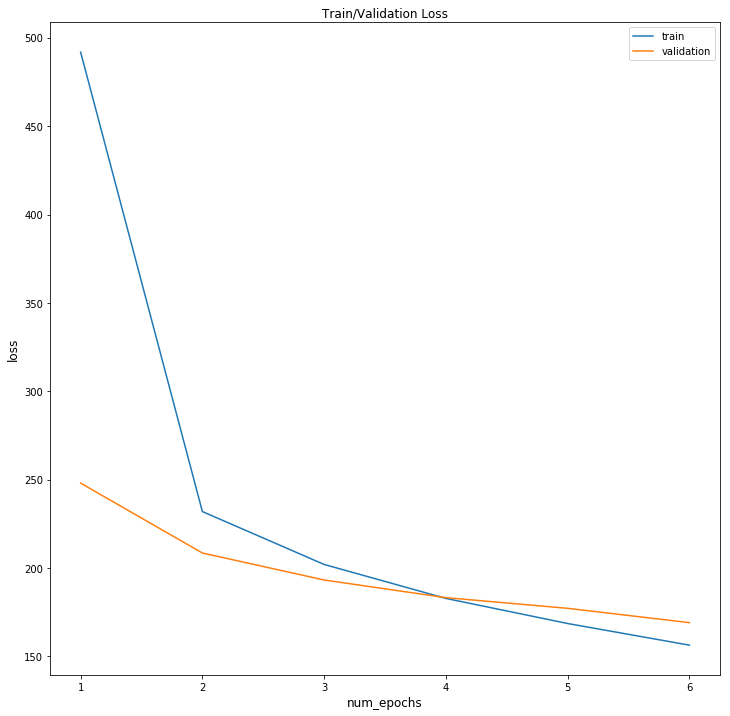

In [ ]:
plot_graph(n_epochs)

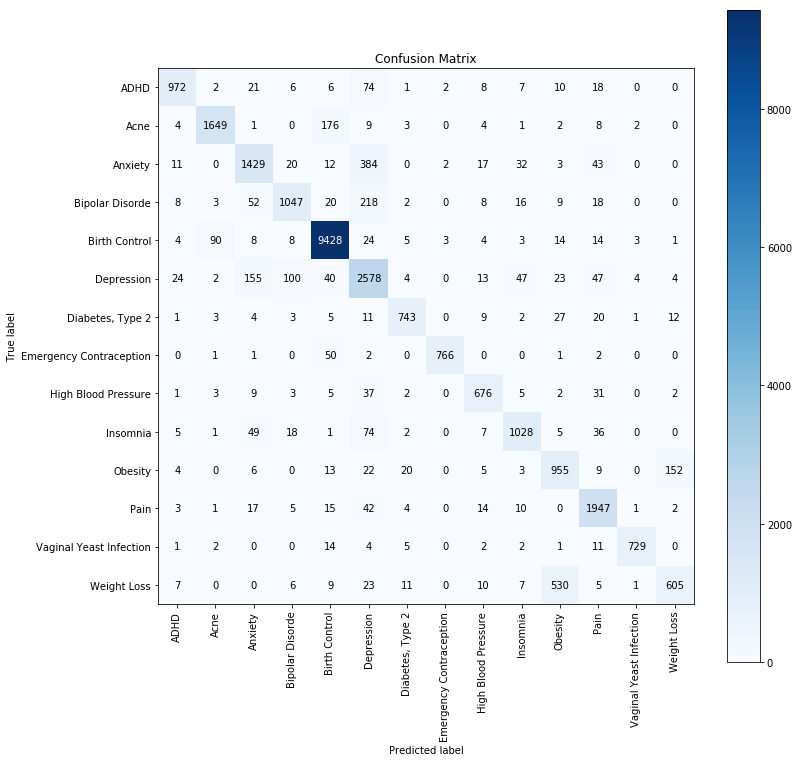

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

## Pytorch Model - BiLSTM

In [ ]:
class BiLSTM(nn.Module):
    
    def __init__(self, max_features, embed_size, hidden_size, drp, n_layers, n_classes):
        super(BiLSTM, self).__init__()
        # self.hidden_size = 64
        # drp = 0.1
        # n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size*4 , hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(hidden_size, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

### Training and testing function

In [ ]:

#Full Training
# train_X = full_train_X
# train_Y = full_train_Y

# val_X = test_X
# val_Y = test_Y

def train_and_validate(params):
  n_epochs = params['n_epochs']
  hidden_size = params['hidden_size']
  drop_rate = params['drop_rate']
  n_layers = params['n_layers']
  n_classes = len(le.classes_)
  embed_size = 300 
  max_features = 12000
  learning_rate = params['learning_rate']

  model = BiLSTM(max_features, embed_size, hidden_size, drop_rate, n_layers, n_classes)
  loss_fn = nn.CrossEntropyLoss(reduction='sum')
  model.cuda()
  # optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
  optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr= params['learning_rate'])


  # Load train and test in CUDA Memory
  x_train = torch.tensor(train_X, dtype=torch.long).cuda()
  y_train = torch.tensor(train_Y, dtype=torch.long).cuda()
  x_cv = torch.tensor(val_X, dtype=torch.long).cuda()
  y_cv = torch.tensor(val_Y, dtype=torch.long).cuda()

  # Create Torch datasets
  train = torch.utils.data.TensorDataset(x_train, y_train)
  valid = torch.utils.data.TensorDataset(x_cv, y_cv)

  # train = DatasetMaper(x_train, y_train)
  # valid = DatasetMaper(x_cv, y_cv)

  # Create Data Loaders
  train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

  train_loss = []
  valid_loss = []

  for epoch in range(n_epochs):
      start_time = time.time()
      # Set model to train configuration
      model.train()
      avg_loss = 0.  
      for i, (x_batch, y_batch) in enumerate(train_loader):
          # Predict/Forward Pass
          y_pred = model(x_batch)
          # Compute loss
          loss = loss_fn(y_pred, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          avg_loss += loss.item() / len(train_loader)
      
      # Set model to validation configuration -Doesn't get trained here
      model.eval()        
      avg_val_loss = 0.
      val_preds = np.zeros((len(x_cv),len(le.classes_)))
      
      for i, (x_batch, y_batch) in enumerate(valid_loader):
          y_pred = model(x_batch).detach()
          avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
          # keep/store predictions
          val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
      
      # Check Accuracy
      val_accuracy = sum(val_preds.argmax(axis=1)==val_Y)/len(val_Y)
      train_loss.append(avg_loss)
      valid_loss.append(avg_val_loss)
      elapsed_time = time.time() - start_time 
      print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                  epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))
  f_score = f1_score(val_Y, val_preds.argmax(axis=1), average='micro')
  # print(evaluate(model))
  return f_score

In [ ]:

def evaluate(model):
  x_test = torch.tensor(test_X, dtype=torch.long).cuda()
  y_test = torch.tensor(test_Y, dtype=torch.long).cuda()

  test = torch.utils.data.TensorDataset(x_test, y_test)

  test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

  test_preds = np.zeros((len(x_test),len(le.classes_)))
  avg_test_loss = 0
  for i, (x_batch, y_batch) in enumerate(test_loader):
      y_pred = model(x_batch).detach()
      # avg_test_loss += loss_fn(y_pred, y_batch).item() / len(test_loader)
      # keep/store predictions
      test_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
  
  # Check Accuracy
  # print(len(test_Y))
  # print(test_preds.argmax(axis=1))
  test_accuracy = sum(test_preds.argmax(axis=1)==test_Y)/len(test_Y)
  print(classification_report(test_Y, test_preds.argmax(axis=1), target_names=[label_indices[0],label_indices[1]]))
  return test_accuracy

In [ ]:
def save_checkpoint(filename, epoch, model):
    state = {
        'epoch': epoch,
        'model': model,
        #'optimizer': optimizer,
        }
    torch.save(state, filename)

In [ ]:
def train_on_full_data(params):
  n_epochs = params['n_epochs']
  hidden_size = params['hidden_size']
  drop_rate = params['drop_rate']
  n_layers = params['n_layers']
  learning_rate = params['learning_rate']
  n_classes = len(le.classes_)

  model = BiLSTM(max_features, embed_size, hidden_size, drop_rate, n_layers, n_classes)
  loss_fn = nn.CrossEntropyLoss(reduction='sum')
  model.cuda()
  # optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
  optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr= params['learning_rate'])


  x_train = torch.tensor(full_train_X, dtype=torch.long).cuda()
  y_train = torch.tensor(full_train_Y, dtype=torch.long).cuda()
  train = torch.utils.data.TensorDataset(x_train, y_train)
  train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)

  train_loss = []

  for epoch in range(n_epochs):
      start_time = time.time()
      # Set model to train configuration
      model.train()
      avg_loss = 0.
      
      for i, (x_batch, y_batch) in enumerate(train_loader):
          # Predict/Forward Pass
          y_pred = model(x_batch)
          # Compute loss
          loss = loss_fn(y_pred, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          avg_loss += loss.item() / len(train_loader)

      train_loss.append(avg_loss)
      elapsed_time = time.time() - start_time 
      
      print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
                  epoch + 1, n_epochs, avg_loss, elapsed_time))
  file_name = 'checkpoints/saved_weights.pt'
  
  save_checkpoint(file_name, epoch, model)
  return evaluate(model)

### Hyper Parameter Tuning using Bayesian Optimization

In [ ]:
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'n_layers': trial.suggest_int("n_layers", 1, 4),
              'drop_rate':trial.suggest_float("drop_rate", 0.1, 0.5),
              'hidden_size': trial.suggest_int("hidden_size", 48, 128),
              'n_epochs': trial.suggest_int("n_epochs", 2, 8),
              }
    
    
    f_score = train_and_validate(params)

    return f_score

In [ ]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=35)
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

[I 2023-01-27 18:38:02,517] A new study created in memory with name: no-name-66de36df-f4d6-47e9-ae7c-c10733540401
<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/7 	 loss=10.8118 	 val_loss=9.5264  	 val_acc=0.9739  	 time=1.51s
Epoch 2/7 	 loss=9.9812 	 val_loss=8.6377  	 val_acc=0.9826  	 time=0.31s
Epoch 3/7 	 loss=8.3506 	 val_loss=6.8839  	 val_acc=0.9304  	 time=0.31s
Epoch 4/7 	 loss=5.6575 	 val_loss=4.0639  	 val_acc=0.9391  	 time=0.32s
Epoch 5/7 	 loss=2.9357 	 val_loss=1.8125  	 val_acc=1.0000  	 time=0.31s
Epoch 6/7 	 loss=1.2853 	 val_loss=1.1316  	 val_acc=0.9565  	 time=0.31s


[I 2023-01-27 18:38:15,693] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.00013925406894987598, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.3133126915599974, 'hidden_size': 92, 'n_epochs': 7}. Best is trial 0 with value: 1.0.


Epoch 7/7 	 loss=0.9673 	 val_loss=1.1432  	 val_acc=1.0000  	 time=0.31s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/3 	 loss=11.0060 	 val_loss=9.9293  	 val_acc=0.4957  	 time=0.23s
Epoch 2/3 	 loss=10.8603 	 val_loss=9.8408  	 val_acc=0.4957  	 time=0.22s


[I 2023-01-27 18:38:16,411] Trial 1 finished with value: 0.4956521739130435 and parameters: {'learning_rate': 0.00011409482781963235, 'optimizer': 'Adam', 'n_layers': 3, 'drop_rate': 0.4721962329345235, 'hidden_size': 58, 'n_epochs': 3}. Best is trial 0 with value: 1.0.


Epoch 3/3 	 loss=10.7619 	 val_loss=9.7421  	 val_acc=0.4957  	 time=0.22s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/4 	 loss=11.0076 	 val_loss=9.9859  	 val_acc=0.2870  	 time=0.56s
Epoch 2/4 	 loss=10.9831 	 val_loss=9.9828  	 val_acc=0.3217  	 time=0.56s
Epoch 3/4 	 loss=10.9982 	 val_loss=9.9798  	 val_acc=0.3565  	 time=0.56s


[I 2023-01-27 18:38:18,695] Trial 2 finished with value: 0.4000000000000001 and parameters: {'learning_rate': 7.079764941264458e-05, 'optimizer': 'SGD', 'n_layers': 2, 'drop_rate': 0.3073744239023778, 'hidden_size': 118, 'n_epochs': 4}. Best is trial 0 with value: 1.0.


Epoch 4/4 	 loss=10.9941 	 val_loss=9.9765  	 val_acc=0.4000  	 time=0.56s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/2 	 loss=11.0402 	 val_loss=9.9940  	 val_acc=0.4696  	 time=0.26s


[I 2023-01-27 18:38:19,261] Trial 3 finished with value: 0.46956521739130436 and parameters: {'learning_rate': 0.00020478970582602516, 'optimizer': 'SGD', 'n_layers': 2, 'drop_rate': 0.18442590232411643, 'hidden_size': 65, 'n_epochs': 2}. Best is trial 0 with value: 1.0.


Epoch 2/2 	 loss=11.0616 	 val_loss=9.9876  	 val_acc=0.4696  	 time=0.26s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/3 	 loss=10.9558 	 val_loss=9.9539  	 val_acc=0.4957  	 time=0.32s
Epoch 2/3 	 loss=10.9557 	 val_loss=9.9431  	 val_acc=0.4957  	 time=0.32s


[I 2023-01-27 18:38:20,245] Trial 4 finished with value: 0.4956521739130435 and parameters: {'learning_rate': 0.0003083587021900847, 'optimizer': 'SGD', 'n_layers': 1, 'drop_rate': 0.3557918928990672, 'hidden_size': 89, 'n_epochs': 3}. Best is trial 0 with value: 1.0.


Epoch 3/3 	 loss=10.9777 	 val_loss=9.9346  	 val_acc=0.4957  	 time=0.32s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/4 	 loss=10.8727 	 val_loss=9.7458  	 val_acc=0.9652  	 time=0.56s
Epoch 2/4 	 loss=10.5801 	 val_loss=9.5670  	 val_acc=0.7043  	 time=0.56s
Epoch 3/4 	 loss=10.3221 	 val_loss=9.3142  	 val_acc=0.9739  	 time=0.56s


[I 2023-01-27 18:38:22,519] Trial 5 finished with value: 0.9826086956521739 and parameters: {'learning_rate': 5.9818031859053646e-05, 'optimizer': 'RMSprop', 'n_layers': 3, 'drop_rate': 0.4817907192661891, 'hidden_size': 120, 'n_epochs': 4}. Best is trial 0 with value: 1.0.


Epoch 4/4 	 loss=9.9374 	 val_loss=8.9895  	 val_acc=0.9826  	 time=0.56s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/7 	 loss=10.9709 	 val_loss=9.8310  	 val_acc=0.6696  	 time=0.27s
Epoch 2/7 	 loss=10.7492 	 val_loss=9.6645  	 val_acc=0.6348  	 time=0.28s
Epoch 3/7 	 loss=10.4800 	 val_loss=9.3877  	 val_acc=0.8000  	 time=0.27s
Epoch 4/7 	 loss=9.9434 	 val_loss=8.8227  	 val_acc=0.9652  	 time=0.28s
Epoch 5/7 	 loss=9.0317 	 val_loss=7.7565  	 val_acc=0.9478  	 time=0.28s
Epoch 6/7 	 loss=7.3091 	 val_loss=5.9253  	 val_acc=0.9652  	 time=0.27s


[I 2023-01-27 18:38:24,474] Trial 6 finished with value: 0.9652173913043478 and parameters: {'learning_rate': 0.00015807356702282545, 'optimizer': 'Adam', 'n_layers': 3, 'drop_rate': 0.1223695371880937, 'hidden_size': 70, 'n_epochs': 7}. Best is trial 0 with value: 1.0.


Epoch 7/7 	 loss=4.7190 	 val_loss=3.2769  	 val_acc=0.9652  	 time=0.27s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/8 	 loss=10.9339 	 val_loss=9.8896  	 val_acc=0.5130  	 time=0.29s
Epoch 2/8 	 loss=10.8106 	 val_loss=9.8097  	 val_acc=0.7565  	 time=0.29s
Epoch 3/8 	 loss=10.6977 	 val_loss=9.7287  	 val_acc=0.9391  	 time=0.29s
Epoch 4/8 	 loss=10.5529 	 val_loss=9.6302  	 val_acc=0.8522  	 time=0.29s
Epoch 5/8 	 loss=10.4099 	 val_loss=9.5079  	 val_acc=0.9478  	 time=0.29s
Epoch 6/8 	 loss=10.2917 	 val_loss=9.3633  	 val_acc=0.9391  	 time=0.29s
Epoch 7/8 	 loss=10.0211 	 val_loss=9.1799  	 val_acc=0.9565  	 time=0.29s


[I 2023-01-27 18:38:26,838] Trial 7 finished with value: 0.9391304347826087 and parameters: {'learning_rate': 5.994438668580415e-05, 'optimizer': 'Adam', 'n_layers': 4, 'drop_rate': 0.4737942159538837, 'hidden_size': 80, 'n_epochs': 8}. Best is trial 0 with value: 1.0.


Epoch 8/8 	 loss=9.8324 	 val_loss=8.9473  	 val_acc=0.9391  	 time=0.29s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/8 	 loss=10.9635 	 val_loss=9.9864  	 val_acc=0.4957  	 time=0.54s
Epoch 2/8 	 loss=10.9957 	 val_loss=9.9857  	 val_acc=0.4957  	 time=0.54s
Epoch 3/8 	 loss=10.9982 	 val_loss=9.9851  	 val_acc=0.4957  	 time=0.53s
Epoch 4/8 	 loss=11.0016 	 val_loss=9.9843  	 val_acc=0.4957  	 time=0.54s
Epoch 5/8 	 loss=10.9647 	 val_loss=9.9836  	 val_acc=0.4957  	 time=0.53s
Epoch 6/8 	 loss=10.9795 	 val_loss=9.9829  	 val_acc=0.4957  	 time=0.53s
Epoch 7/8 	 loss=10.9865 	 val_loss=9.9821  	 val_acc=0.4957  	 time=0.54s


[I 2023-01-27 18:38:31,162] Trial 8 finished with value: 0.4956521739130435 and parameters: {'learning_rate': 1.8593176107281284e-05, 'optimizer': 'SGD', 'n_layers': 3, 'drop_rate': 0.3840082098229196, 'hidden_size': 104, 'n_epochs': 8}. Best is trial 0 with value: 1.0.


Epoch 8/8 	 loss=10.9634 	 val_loss=9.9815  	 val_acc=0.4957  	 time=0.54s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/7 	 loss=44.2553 	 val_loss=2.2956  	 val_acc=0.9652  	 time=0.29s
Epoch 2/7 	 loss=2.0886 	 val_loss=0.8665  	 val_acc=0.9826  	 time=0.29s
Epoch 3/7 	 loss=0.6869 	 val_loss=0.3812  	 val_acc=0.9913  	 time=0.30s
Epoch 4/7 	 loss=0.2775 	 val_loss=0.3065  	 val_acc=0.9913  	 time=0.29s
Epoch 5/7 	 loss=0.3341 	 val_loss=0.3861  	 val_acc=0.9913  	 time=0.29s
Epoch 6/7 	 loss=0.2974 	 val_loss=0.2257  	 val_acc=0.9913  	 time=0.29s


[I 2023-01-27 18:38:33,232] Trial 9 finished with value: 0.991304347826087 and parameters: {'learning_rate': 0.008794874198297805, 'optimizer': 'RMSprop', 'n_layers': 4, 'drop_rate': 0.31939145195608676, 'hidden_size': 78, 'n_epochs': 7}. Best is trial 0 with value: 1.0.


Epoch 7/7 	 loss=0.1067 	 val_loss=0.2148  	 val_acc=0.9913  	 time=0.29s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=9.1330 	 val_loss=4.6912  	 val_acc=0.8609  	 time=0.20s
Epoch 2/6 	 loss=1.6982 	 val_loss=0.4588  	 val_acc=0.9913  	 time=0.20s
Epoch 3/6 	 loss=0.2797 	 val_loss=0.2076  	 val_acc=1.0000  	 time=0.20s
Epoch 4/6 	 loss=0.0927 	 val_loss=0.0888  	 val_acc=1.0000  	 time=0.51s


[I 2023-01-27 18:38:34,894] Trial 10 finished with value: 1.0 and parameters: {'learning_rate': 0.0011372083309553107, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.23765828663537486, 'hidden_size': 48, 'n_epochs': 6}. Best is trial 0 with value: 1.0.


Epoch 5/6 	 loss=0.0520 	 val_loss=0.0644  	 val_acc=1.0000  	 time=0.30s
Epoch 6/6 	 loss=0.0302 	 val_loss=0.0460  	 val_acc=1.0000  	 time=0.19s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=11.1523 	 val_loss=9.9925  	 val_acc=0.5043  	 time=0.21s
Epoch 2/6 	 loss=10.9339 	 val_loss=9.7388  	 val_acc=0.5826  	 time=0.39s
Epoch 3/6 	 loss=9.6170 	 val_loss=6.1069  	 val_acc=0.9565  	 time=0.35s
Epoch 4/6 	 loss=3.5498 	 val_loss=1.4131  	 val_acc=0.9826  	 time=0.22s
Epoch 5/6 	 loss=1.3506 	 val_loss=0.4097  	 val_acc=0.9913  	 time=0.22s


[I 2023-01-27 18:38:36,557] Trial 11 finished with value: 1.0 and parameters: {'learning_rate': 0.0008647004188304768, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.23138853114420854, 'hidden_size': 51, 'n_epochs': 6}. Best is trial 0 with value: 1.0.


Epoch 6/6 	 loss=0.6434 	 val_loss=0.2979  	 val_acc=1.0000  	 time=0.21s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=7.5776 	 val_loss=1.1623  	 val_acc=0.9826  	 time=0.56s
Epoch 2/6 	 loss=0.4831 	 val_loss=0.2079  	 val_acc=1.0000  	 time=0.56s
Epoch 3/6 	 loss=0.0870 	 val_loss=0.1163  	 val_acc=1.0000  	 time=0.56s
Epoch 4/6 	 loss=0.0398 	 val_loss=0.0714  	 val_acc=1.0000  	 time=0.56s
Epoch 5/6 	 loss=0.0255 	 val_loss=0.0349  	 val_acc=1.0000  	 time=0.56s


[I 2023-01-27 18:38:39,957] Trial 12 finished with value: 1.0 and parameters: {'learning_rate': 0.0011250172722568376, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.24829856688259672, 'hidden_size': 101, 'n_epochs': 6}. Best is trial 0 with value: 1.0.


Epoch 6/6 	 loss=0.0194 	 val_loss=0.0300  	 val_acc=1.0000  	 time=0.56s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=8.0704 	 val_loss=3.4997  	 val_acc=0.9391  	 time=0.33s
Epoch 2/6 	 loss=1.5167 	 val_loss=0.4275  	 val_acc=1.0000  	 time=0.33s
Epoch 3/6 	 loss=0.1957 	 val_loss=0.2570  	 val_acc=1.0000  	 time=0.33s
Epoch 4/6 	 loss=0.0778 	 val_loss=0.0847  	 val_acc=1.0000  	 time=0.32s
Epoch 5/6 	 loss=0.0350 	 val_loss=0.0837  	 val_acc=1.0000  	 time=0.33s


[I 2023-01-27 18:38:42,007] Trial 13 finished with value: 1.0 and parameters: {'learning_rate': 0.0009515442994677754, 'optimizer': 'RMSprop', 'n_layers': 2, 'drop_rate': 0.2493096361280928, 'hidden_size': 95, 'n_epochs': 6}. Best is trial 0 with value: 1.0.


Epoch 6/6 	 loss=0.0152 	 val_loss=0.0845  	 val_acc=1.0000  	 time=0.34s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=10.9230 	 val_loss=9.8694  	 val_acc=0.5043  	 time=0.59s
Epoch 2/5 	 loss=10.8636 	 val_loss=9.8363  	 val_acc=0.5913  	 time=0.59s
Epoch 3/5 	 loss=10.8124 	 val_loss=9.8105  	 val_acc=0.8609  	 time=0.59s
Epoch 4/5 	 loss=10.7847 	 val_loss=9.7862  	 val_acc=0.9043  	 time=0.59s


[I 2023-01-27 18:38:45,014] Trial 14 finished with value: 0.9217391304347826 and parameters: {'learning_rate': 1.1832171240906281e-05, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.17227292544916992, 'hidden_size': 109, 'n_epochs': 5}. Best is trial 0 with value: 1.0.


Epoch 5/5 	 loss=10.7339 	 val_loss=9.7630  	 val_acc=0.9217  	 time=0.59s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/7 	 loss=9.5925 	 val_loss=5.5241  	 val_acc=0.9913  	 time=0.20s
Epoch 2/7 	 loss=3.2392 	 val_loss=1.5792  	 val_acc=0.9739  	 time=0.20s
Epoch 3/7 	 loss=1.9332 	 val_loss=1.2066  	 val_acc=0.9652  	 time=0.20s
Epoch 4/7 	 loss=0.5510 	 val_loss=0.6087  	 val_acc=0.9913  	 time=0.20s
Epoch 5/7 	 loss=0.2733 	 val_loss=0.3189  	 val_acc=1.0000  	 time=0.21s
Epoch 6/7 	 loss=0.1573 	 val_loss=0.1915  	 val_acc=1.0000  	 time=0.20s


[I 2023-01-27 18:38:46,478] Trial 15 finished with value: 1.0 and parameters: {'learning_rate': 0.0005267836458950588, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.2842725072254969, 'hidden_size': 48, 'n_epochs': 7}. Best is trial 0 with value: 1.0.


Epoch 7/7 	 loss=0.0886 	 val_loss=0.1517  	 val_acc=1.0000  	 time=0.20s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=12.6596 	 val_loss=4.3791  	 val_acc=0.8957  	 time=0.31s
Epoch 2/5 	 loss=1.8020 	 val_loss=0.8076  	 val_acc=0.9826  	 time=0.31s
Epoch 3/5 	 loss=0.3164 	 val_loss=0.3821  	 val_acc=0.9913  	 time=0.32s
Epoch 4/5 	 loss=0.1779 	 val_loss=0.2155  	 val_acc=0.9913  	 time=0.31s


[I 2023-01-27 18:38:48,100] Trial 16 finished with value: 0.991304347826087 and parameters: {'learning_rate': 0.002463858683542979, 'optimizer': 'RMSprop', 'n_layers': 2, 'drop_rate': 0.40498909374577396, 'hidden_size': 82, 'n_epochs': 5}. Best is trial 0 with value: 1.0.


Epoch 5/5 	 loss=0.1278 	 val_loss=0.2123  	 val_acc=0.9913  	 time=0.31s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/7 	 loss=10.1612 	 val_loss=7.4464  	 val_acc=0.9739  	 time=0.28s
Epoch 2/7 	 loss=5.0872 	 val_loss=2.6099  	 val_acc=0.9478  	 time=0.27s
Epoch 3/7 	 loss=1.2840 	 val_loss=1.1216  	 val_acc=0.9739  	 time=0.28s
Epoch 4/7 	 loss=0.9198 	 val_loss=0.9720  	 val_acc=0.9739  	 time=0.28s
Epoch 5/7 	 loss=0.5327 	 val_loss=0.4757  	 val_acc=0.9913  	 time=0.28s
Epoch 6/7 	 loss=0.2097 	 val_loss=0.3302  	 val_acc=0.9913  	 time=0.28s


[I 2023-01-27 18:38:50,097] Trial 17 finished with value: 0.991304347826087 and parameters: {'learning_rate': 0.0003414400264167762, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.3417421534429189, 'hidden_size': 69, 'n_epochs': 7}. Best is trial 0 with value: 1.0.


Epoch 7/7 	 loss=0.1260 	 val_loss=0.3269  	 val_acc=0.9913  	 time=0.28s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=12.7175 	 val_loss=1.5071  	 val_acc=0.9739  	 time=0.60s
Epoch 2/6 	 loss=0.4515 	 val_loss=0.4170  	 val_acc=0.9913  	 time=0.60s
Epoch 3/6 	 loss=0.0688 	 val_loss=0.3085  	 val_acc=0.9913  	 time=0.59s
Epoch 4/6 	 loss=0.0330 	 val_loss=0.2571  	 val_acc=0.9913  	 time=0.60s
Epoch 5/6 	 loss=0.0189 	 val_loss=0.2898  	 val_acc=0.9913  	 time=0.61s


[I 2023-01-27 18:38:53,746] Trial 18 finished with value: 0.991304347826087 and parameters: {'learning_rate': 0.002201031391228526, 'optimizer': 'RMSprop', 'n_layers': 2, 'drop_rate': 0.2821921271348488, 'hidden_size': 127, 'n_epochs': 6}. Best is trial 0 with value: 1.0.


Epoch 6/6 	 loss=0.0096 	 val_loss=0.2800  	 val_acc=0.9913  	 time=0.60s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/8 	 loss=10.9097 	 val_loss=9.8798  	 val_acc=0.5043  	 time=0.33s
Epoch 2/8 	 loss=10.8417 	 val_loss=9.8317  	 val_acc=0.5217  	 time=0.32s
Epoch 3/8 	 loss=10.7498 	 val_loss=9.7879  	 val_acc=0.7217  	 time=0.33s
Epoch 4/8 	 loss=10.6985 	 val_loss=9.7410  	 val_acc=0.6870  	 time=0.33s
Epoch 5/8 	 loss=10.6571 	 val_loss=9.6923  	 val_acc=0.8000  	 time=0.33s
Epoch 6/8 	 loss=10.5606 	 val_loss=9.6374  	 val_acc=0.7652  	 time=0.34s
Epoch 7/8 	 loss=10.4919 	 val_loss=9.5757  	 val_acc=0.9043  	 time=0.33s


[I 2023-01-27 18:38:56,443] Trial 19 finished with value: 0.9217391304347826 and parameters: {'learning_rate': 2.7939757347178512e-05, 'optimizer': 'Adam', 'n_layers': 1, 'drop_rate': 0.20647869602475366, 'hidden_size': 89, 'n_epochs': 8}. Best is trial 0 with value: 1.0.


Epoch 8/8 	 loss=10.4262 	 val_loss=9.5059  	 val_acc=0.9217  	 time=0.33s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=10.5720 	 val_loss=8.5945  	 val_acc=0.9391  	 time=0.23s
Epoch 2/5 	 loss=7.1210 	 val_loss=4.2585  	 val_acc=0.9130  	 time=0.22s
Epoch 3/5 	 loss=2.6870 	 val_loss=2.0741  	 val_acc=1.0000  	 time=0.23s
Epoch 4/5 	 loss=1.2888 	 val_loss=1.8057  	 val_acc=0.9478  	 time=0.23s


[I 2023-01-27 18:38:57,639] Trial 20 finished with value: 0.9826086956521739 and parameters: {'learning_rate': 0.00029946186189297875, 'optimizer': 'RMSprop', 'n_layers': 2, 'drop_rate': 0.27302588938159117, 'hidden_size': 61, 'n_epochs': 5}. Best is trial 0 with value: 1.0.


Epoch 5/5 	 loss=0.7935 	 val_loss=0.8430  	 val_acc=0.9826  	 time=0.23s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=8.9892 	 val_loss=4.2236  	 val_acc=0.9478  	 time=0.21s
Epoch 2/6 	 loss=2.0356 	 val_loss=2.4030  	 val_acc=0.9391  	 time=0.22s
Epoch 3/6 	 loss=0.4516 	 val_loss=0.4616  	 val_acc=0.9913  	 time=0.21s
Epoch 4/6 	 loss=0.3268 	 val_loss=0.1894  	 val_acc=1.0000  	 time=0.21s
Epoch 5/6 	 loss=0.1145 	 val_loss=0.0968  	 val_acc=1.0000  	 time=0.21s


[I 2023-01-27 18:38:58,977] Trial 21 finished with value: 1.0 and parameters: {'learning_rate': 0.0006123392890400335, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.23131731563611146, 'hidden_size': 50, 'n_epochs': 6}. Best is trial 0 with value: 1.0.


Epoch 6/6 	 loss=0.0534 	 val_loss=0.0683  	 val_acc=1.0000  	 time=0.21s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=6.4744 	 val_loss=1.0942  	 val_acc=0.9826  	 time=0.22s
Epoch 2/6 	 loss=0.4748 	 val_loss=0.2266  	 val_acc=1.0000  	 time=0.22s
Epoch 3/6 	 loss=0.0825 	 val_loss=0.1030  	 val_acc=1.0000  	 time=0.23s
Epoch 4/6 	 loss=0.0384 	 val_loss=0.0412  	 val_acc=1.0000  	 time=0.21s
Epoch 5/6 	 loss=0.0209 	 val_loss=0.0318  	 val_acc=1.0000  	 time=0.21s


[I 2023-01-27 18:39:00,346] Trial 22 finished with value: 1.0 and parameters: {'learning_rate': 0.0016162572048122326, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.2248194049420122, 'hidden_size': 52, 'n_epochs': 6}. Best is trial 0 with value: 1.0.


Epoch 6/6 	 loss=0.0128 	 val_loss=0.0272  	 val_acc=1.0000  	 time=0.22s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/7 	 loss=10.2597 	 val_loss=6.6920  	 val_acc=0.9565  	 time=0.22s
Epoch 2/7 	 loss=4.2583 	 val_loss=1.5302  	 val_acc=0.9913  	 time=0.23s
Epoch 3/7 	 loss=1.1637 	 val_loss=0.7072  	 val_acc=1.0000  	 time=0.22s
Epoch 4/7 	 loss=0.4606 	 val_loss=0.3787  	 val_acc=0.9826  	 time=0.23s
Epoch 5/7 	 loss=0.1529 	 val_loss=0.3687  	 val_acc=0.9913  	 time=0.23s
Epoch 6/7 	 loss=0.0769 	 val_loss=0.3604  	 val_acc=0.9913  	 time=0.23s


[I 2023-01-27 18:39:01,985] Trial 23 finished with value: 0.991304347826087 and parameters: {'learning_rate': 0.0005883064926942359, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.26491705749467437, 'hidden_size': 59, 'n_epochs': 7}. Best is trial 0 with value: 1.0.


Epoch 7/7 	 loss=0.0544 	 val_loss=0.3648  	 val_acc=0.9913  	 time=0.22s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=12.9150 	 val_loss=1.3403  	 val_acc=0.9652  	 time=0.28s
Epoch 2/6 	 loss=0.6432 	 val_loss=0.2462  	 val_acc=0.9913  	 time=0.29s
Epoch 3/6 	 loss=0.2092 	 val_loss=0.1208  	 val_acc=1.0000  	 time=0.29s
Epoch 4/6 	 loss=0.0721 	 val_loss=0.1034  	 val_acc=1.0000  	 time=0.29s
Epoch 5/6 	 loss=0.0400 	 val_loss=0.0932  	 val_acc=1.0000  	 time=0.29s


[I 2023-01-27 18:39:03,766] Trial 24 finished with value: 1.0 and parameters: {'learning_rate': 0.0038104157961630246, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.30405519881330534, 'hidden_size': 74, 'n_epochs': 6}. Best is trial 0 with value: 1.0.


Epoch 6/6 	 loss=0.0451 	 val_loss=0.0841  	 val_acc=1.0000  	 time=0.29s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/4 	 loss=8.6958 	 val_loss=2.8755  	 val_acc=0.9739  	 time=0.22s
Epoch 2/4 	 loss=1.1999 	 val_loss=1.5742  	 val_acc=0.9391  	 time=0.22s
Epoch 3/4 	 loss=0.2642 	 val_loss=0.1065  	 val_acc=1.0000  	 time=0.22s


[I 2023-01-27 18:39:04,698] Trial 25 finished with value: 1.0 and parameters: {'learning_rate': 0.0009639687528954852, 'optimizer': 'RMSprop', 'n_layers': 2, 'drop_rate': 0.20318557998039188, 'hidden_size': 55, 'n_epochs': 4}. Best is trial 0 with value: 1.0.


Epoch 4/4 	 loss=0.0667 	 val_loss=0.0547  	 val_acc=1.0000  	 time=0.22s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=9.9166 	 val_loss=6.4392  	 val_acc=0.8870  	 time=0.22s
Epoch 2/5 	 loss=3.9005 	 val_loss=1.4076  	 val_acc=0.9739  	 time=0.23s
Epoch 3/5 	 loss=0.8836 	 val_loss=0.4387  	 val_acc=0.9913  	 time=0.23s
Epoch 4/5 	 loss=0.9604 	 val_loss=0.6484  	 val_acc=0.9913  	 time=0.23s


[I 2023-01-27 18:39:05,898] Trial 26 finished with value: 1.0 and parameters: {'learning_rate': 0.0004546002638307066, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.16235729638688362, 'hidden_size': 64, 'n_epochs': 5}. Best is trial 0 with value: 1.0.


Epoch 5/5 	 loss=0.2503 	 val_loss=0.1942  	 val_acc=1.0000  	 time=0.23s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/7 	 loss=10.6358 	 val_loss=8.8028  	 val_acc=0.8348  	 time=0.33s
Epoch 2/7 	 loss=7.8822 	 val_loss=5.3370  	 val_acc=0.9478  	 time=0.33s
Epoch 3/7 	 loss=3.5452 	 val_loss=2.2592  	 val_acc=0.9565  	 time=0.34s
Epoch 4/7 	 loss=1.2997 	 val_loss=1.2980  	 val_acc=0.9652  	 time=0.33s
Epoch 5/7 	 loss=0.6413 	 val_loss=0.5532  	 val_acc=1.0000  	 time=0.34s
Epoch 6/7 	 loss=0.4753 	 val_loss=0.3407  	 val_acc=1.0000  	 time=0.35s


[I 2023-01-27 18:39:08,323] Trial 27 finished with value: 1.0 and parameters: {'learning_rate': 0.0001913492445908548, 'optimizer': 'RMSprop', 'n_layers': 2, 'drop_rate': 0.24638512059015633, 'hidden_size': 93, 'n_epochs': 7}. Best is trial 0 with value: 1.0.


Epoch 7/7 	 loss=0.3024 	 val_loss=0.3413  	 val_acc=1.0000  	 time=0.34s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/8 	 loss=10.5349 	 val_loss=8.7290  	 val_acc=0.7652  	 time=0.34s
Epoch 2/8 	 loss=5.9664 	 val_loss=1.7973  	 val_acc=0.9652  	 time=0.33s
Epoch 3/8 	 loss=1.3109 	 val_loss=1.5502  	 val_acc=0.9478  	 time=0.34s
Epoch 4/8 	 loss=0.2507 	 val_loss=0.2846  	 val_acc=0.9913  	 time=0.33s
Epoch 5/8 	 loss=0.0615 	 val_loss=0.1243  	 val_acc=1.0000  	 time=0.33s
Epoch 6/8 	 loss=0.0256 	 val_loss=0.1325  	 val_acc=1.0000  	 time=0.33s
Epoch 7/8 	 loss=0.0221 	 val_loss=0.1070  	 val_acc=1.0000  	 time=0.34s


[I 2023-01-27 18:39:11,106] Trial 28 finished with value: 0.991304347826087 and parameters: {'learning_rate': 0.0009105771632330032, 'optimizer': 'Adam', 'n_layers': 1, 'drop_rate': 0.21087714601060692, 'hidden_size': 84, 'n_epochs': 8}. Best is trial 0 with value: 1.0.


Epoch 8/8 	 loss=0.0147 	 val_loss=0.1289  	 val_acc=0.9913  	 time=0.34s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=10.9788 	 val_loss=9.9293  	 val_acc=0.5043  	 time=0.25s
Epoch 2/6 	 loss=10.9650 	 val_loss=9.9230  	 val_acc=0.5043  	 time=0.23s
Epoch 3/6 	 loss=10.9663 	 val_loss=9.9175  	 val_acc=0.5043  	 time=0.22s
Epoch 4/6 	 loss=10.9467 	 val_loss=9.9128  	 val_acc=0.5043  	 time=0.22s
Epoch 5/6 	 loss=10.9295 	 val_loss=9.9082  	 val_acc=0.5043  	 time=0.22s


[I 2023-01-27 18:39:12,575] Trial 29 finished with value: 0.5043478260869565 and parameters: {'learning_rate': 0.0001465296237964403, 'optimizer': 'SGD', 'n_layers': 1, 'drop_rate': 0.14580669135036828, 'hidden_size': 55, 'n_epochs': 6}. Best is trial 0 with value: 1.0.


Epoch 6/6 	 loss=10.9360 	 val_loss=9.9041  	 val_acc=0.5043  	 time=0.22s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/7 	 loss=10.9895 	 val_loss=9.8710  	 val_acc=0.5565  	 time=0.30s
Epoch 2/7 	 loss=10.8356 	 val_loss=9.7658  	 val_acc=0.6435  	 time=0.29s
Epoch 3/7 	 loss=10.6508 	 val_loss=9.6220  	 val_acc=0.9217  	 time=0.29s
Epoch 4/7 	 loss=10.4090 	 val_loss=9.4279  	 val_acc=0.9304  	 time=0.29s
Epoch 5/7 	 loss=10.1295 	 val_loss=9.1270  	 val_acc=0.9565  	 time=0.29s
Epoch 6/7 	 loss=9.6615 	 val_loss=8.7034  	 val_acc=0.9304  	 time=0.29s


[I 2023-01-27 18:39:14,689] Trial 30 finished with value: 0.9652173913043478 and parameters: {'learning_rate': 9.179848329339065e-05, 'optimizer': 'Adam', 'n_layers': 2, 'drop_rate': 0.11721872850219077, 'hidden_size': 73, 'n_epochs': 7}. Best is trial 0 with value: 1.0.


Epoch 7/7 	 loss=9.0134 	 val_loss=8.1017  	 val_acc=0.9652  	 time=0.29s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=7.0019 	 val_loss=1.2365  	 val_acc=0.9739  	 time=0.55s
Epoch 2/6 	 loss=0.5633 	 val_loss=0.1132  	 val_acc=1.0000  	 time=0.56s
Epoch 3/6 	 loss=0.0748 	 val_loss=0.0373  	 val_acc=1.0000  	 time=0.56s
Epoch 4/6 	 loss=0.0280 	 val_loss=0.0165  	 val_acc=1.0000  	 time=0.55s
Epoch 5/6 	 loss=0.0167 	 val_loss=0.0143  	 val_acc=1.0000  	 time=0.56s


[I 2023-01-27 18:39:18,065] Trial 31 finished with value: 1.0 and parameters: {'learning_rate': 0.0012456841397419237, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.24722984664441205, 'hidden_size': 104, 'n_epochs': 6}. Best is trial 0 with value: 1.0.


Epoch 6/6 	 loss=0.0122 	 val_loss=0.0075  	 val_acc=1.0000  	 time=0.55s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=8.1246 	 val_loss=2.7090  	 val_acc=0.9913  	 time=0.57s
Epoch 2/5 	 loss=1.1607 	 val_loss=0.4821  	 val_acc=1.0000  	 time=0.58s
Epoch 3/5 	 loss=0.1813 	 val_loss=0.2124  	 val_acc=1.0000  	 time=0.57s
Epoch 4/5 	 loss=1.8677 	 val_loss=0.4635  	 val_acc=0.9913  	 time=0.58s


[I 2023-01-27 18:39:20,996] Trial 32 finished with value: 0.991304347826087 and parameters: {'learning_rate': 0.0006771183470107325, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.26005429187694745, 'hidden_size': 101, 'n_epochs': 5}. Best is trial 0 with value: 1.0.


Epoch 5/5 	 loss=0.1575 	 val_loss=0.3043  	 val_acc=0.9913  	 time=0.58s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=7.5124 	 val_loss=2.2274  	 val_acc=0.9391  	 time=0.57s
Epoch 2/6 	 loss=0.5612 	 val_loss=0.1871  	 val_acc=1.0000  	 time=0.58s
Epoch 3/6 	 loss=0.0719 	 val_loss=0.1147  	 val_acc=1.0000  	 time=0.57s
Epoch 4/6 	 loss=0.0321 	 val_loss=0.0977  	 val_acc=1.0000  	 time=0.57s
Epoch 5/6 	 loss=0.0200 	 val_loss=0.0829  	 val_acc=1.0000  	 time=0.57s


[I 2023-01-27 18:39:24,504] Trial 33 finished with value: 1.0 and parameters: {'learning_rate': 0.0015037491327109407, 'optimizer': 'RMSprop', 'n_layers': 1, 'drop_rate': 0.28764939914848126, 'hidden_size': 112, 'n_epochs': 6}. Best is trial 0 with value: 1.0.


Epoch 6/6 	 loss=0.0417 	 val_loss=0.0704  	 val_acc=1.0000  	 time=0.58s


<ipython-input-32-05268f7b54a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
<ipython-input-28-14f87c8d90ff>:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/2 	 loss=11.0626 	 val_loss=10.0396  	 val_acc=0.4957  	 time=0.32s


[I 2023-01-27 18:39:25,204] Trial 34 finished with value: 0.4956521739130435 and parameters: {'learning_rate': 0.00029054082351821325, 'optimizer': 'SGD', 'n_layers': 2, 'drop_rate': 0.19043059230381035, 'hidden_size': 96, 'n_epochs': 2}. Best is trial 0 with value: 1.0.


Epoch 2/2 	 loss=11.0258 	 val_loss=10.0195  	 val_acc=0.4957  	 time=0.32s
learning_rate: 0.00013925406894987598
optimizer: RMSprop
n_layers: 1
drop_rate: 0.3133126915599974
hidden_size: 92
n_epochs: 7


Declaring the best parameters

In [ ]:
best_params = {
    'learning_rate': 0.00013925406894987598,
 'optimizer': 'RMSprop',
 'n_layers': 1,
 'drop_rate': 0.3133126915599974,
 'hidden_size': 92,
 'n_epochs': 7
}

# best_trial.params

Training and testing the model with the best parameters got from hyper parameter tuning on the full training data

In [ ]:
full_train_X = full_train['Statement'] # Full train to be used only after hyper parameter tuning
# full_train_Y = full_train['Measurement']
# full_train_Y = full_train['Time Constraint']
# full_train_Y = full_train['Data Definition']
full_train_Y = full_train['Data Action']
# full_train_Y = full_train['Convention']

test_X = sep_test['Statement']
# test_Y = sep_test['Measurement']
# test_Y = sep_test['Data Definition']
test_Y = sep_test['Data Action']
# test_Y = sep_test['Convention']
# test_Y = sep_test['Time Constraint']

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(full_train_X))
full_train_X = tokenizer.texts_to_sequences(full_train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
full_train_X = pad_sequences(full_train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

le = LabelEncoder()
full_train_Y = le.fit_transform(full_train_Y.values)
test_Y = le.transform(test_Y.values)## Tokenize the sentences

if debug:
    embedding_matrix = np.random.randn(12000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)
train_on_full_data(best_params)
# train_and_validate(best_params)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Epoch 1/7 	 loss=10.2822 	 time=1.81s
Epoch 2/7 	 loss=6.2248 	 time=0.60s
Epoch 3/7 	 loss=2.3177 	 time=0.60s
Epoch 4/7 	 loss=1.6915 	 time=0.60s
Epoch 5/7 	 loss=1.1279 	 time=0.60s
Epoch 6/7 	 loss=0.7485 	 time=0.60s
Epoch 7/7 	 loss=0.5712 	 time=0.61s
                 precision    recall  f1-score   support

not_Data Action       1.00      0.97      0.98       115
    Data Action       0.56      1.00      0.71         5

       accuracy                           0.97       120
      macro avg       0.78      0.98      0.85       120
   weighted avg       0.98      0.97      0.97       120



<ipython-input-24-0e9a28fb5bfd>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  test_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


0.9666666666666667

In [ ]:


for i, (x_batch, y_batch) in enumerate(valid_loader):
      y_pred = model(x_batch).detach()
      avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
      val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
val_accuracy = sum(val_preds.argmax(axis=1)==val_Y)/len(val_Y)
print(val_accuracy)
  


1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [ ]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

In [ ]:
plot_graph(n_epochs)

In [ ]:
torch.save(model,'checkpoints/bilstm_Convention_RE')

## Deploy : Predict A Single Example

In [ ]:
def predict_single(x):    
    # lower the text
    # x = x.lower()
    # Clean the text
    # x =  clean_text(x)
    # Clean numbers
    # x =  clean_numbers(x)
    # Clean Contractions
    # x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [ ]:
le.classes_

array([0., 1.])

### Cross Validation

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
fold = 1

for train_idx, val_idx in kf.split(data):
  train_X = x_data[train_idx]
  train_Y = y_data[train_idx]
  val_X = x_data[val_idx]
  val_Y = y_data[val_idx]

  tokenizer = Tokenizer(num_words=max_features)
  tokenizer.fit_on_texts(list(train_X))
  train_X = tokenizer.texts_to_sequences(train_X)
  val_X = tokenizer.texts_to_sequences(val_X)
  
  train_X = pad_sequences(train_X, maxlen=maxlen)
  val_X = pad_sequences(val_X, maxlen=maxlen)

  le = LabelEncoder()
  train_Y = le.fit_transform(train_Y.values)
  val_Y = le.transform(val_Y.values)

  if debug:
    embedding_matrix = np.random.randn(12000,300)
  else:
      embedding_matrix = load_glove(tokenizer.word_index)

  n_epochs = 5
  model = BiLSTM()
  loss_fn = nn.CrossEntropyLoss(reduction='sum')
  model.cuda()
  optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

  # Load train and test in CUDA Memory
  x_train = torch.tensor(train_X, dtype=torch.long).cuda()
  y_train = torch.tensor(train_Y, dtype=torch.long).cuda()
  x_cv = torch.tensor(val_X, dtype=torch.long).cuda()
  y_cv = torch.tensor(val_Y, dtype=torch.long).cuda()

  # Create Torch datasets
  train = torch.utils.data.TensorDataset(x_train, y_train)
  valid = torch.utils.data.TensorDataset(x_cv, y_cv)

  # train = DatasetMaper(x_train, y_train)
  # valid = DatasetMaper(x_cv, y_cv)

  # Create Data Loaders
  train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

  train_loss = []
  valid_loss = []

  for epoch in range(n_epochs):
      start_time = time.time()
      # Set model to train configuration
      model.train()
      avg_loss = 0.  
      for i, (x_batch, y_batch) in enumerate(train_loader):
          # Predict/Forward Pass
          y_pred = model(x_batch)
          # Compute loss
          loss = loss_fn(y_pred, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          avg_loss += loss.item() / len(train_loader)
      
      # Set model to validation configuration -Doesn't get trained here
      model.eval()        
      avg_val_loss = 0.
      val_preds = np.zeros((len(x_cv),len(le.classes_)))
      
      for i, (x_batch, y_batch) in enumerate(valid_loader):
          y_pred = model(x_batch).detach()
          avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
          # keep/store predictions
          val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
      
      # Check Accuracy
      val_accuracy = sum(val_preds.argmax(axis=1)==val_Y)/len(val_Y)
      train_loss.append(avg_loss)
      valid_loss.append(avg_val_loss)
      elapsed_time = time.time() - start_time 
      print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                  epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))
  
  for i, (x_batch, y_batch) in enumerate(valid_loader):
      y_pred = model(x_batch).detach()
      avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
      val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
  val_accuracy = sum(val_preds.argmax(axis=1)==val_Y)/len(val_Y)
  print("Report for fold ",fold)
  fold = fold + 1
  print(classification_report(val_Y, val_preds.argmax(axis=1), target_names=['not_Measurement', 'Measurement']))

<ipython-input-81-c3ceede7e8d3>:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=8.1638 	 val_loss=6.3264  	 val_acc=0.7843  	 time=0.35s
Epoch 2/5 	 loss=7.2697 	 val_loss=4.9493  	 val_acc=0.7843  	 time=0.24s
Epoch 3/5 	 loss=4.7948 	 val_loss=2.7889  	 val_acc=0.9216  	 time=0.23s
Epoch 4/5 	 loss=3.3703 	 val_loss=2.3698  	 val_acc=0.9608  	 time=0.23s
Epoch 5/5 	 loss=2.7503 	 val_loss=2.0195  	 val_acc=1.0000  	 time=0.23s
Report for fold  1
                 precision    recall  f1-score   support

not_Measurement       1.00      1.00      1.00        40
    Measurement       1.00      1.00      1.00        11

       accuracy                           1.00        51
      macro avg       1.00      1.00      1.00        51
   weighted avg       1.00      1.00      1.00        51



<ipython-input-81-c3ceede7e8d3>:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-81-c3ceede7e8d3>:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=8.3457 	 val_loss=5.8447  	 val_acc=0.8235  	 time=0.33s
Epoch 2/5 	 loss=7.3537 	 val_loss=4.2357  	 val_acc=0.8235  	 time=0.24s
Epoch 3/5 	 loss=4.3791 	 val_loss=2.4990  	 val_acc=0.9412  	 time=0.23s
Epoch 4/5 	 loss=2.7404 	 val_loss=2.8691  	 val_acc=0.9020  	 time=0.23s
Epoch 5/5 	 loss=2.1162 	 val_loss=2.9645  	 val_acc=0.9216  	 time=0.23s
Report for fold  2
                 precision    recall  f1-score   support

not_Measurement       1.00      0.90      0.95        42
    Measurement       0.69      1.00      0.82         9

       accuracy                           0.92        51
      macro avg       0.85      0.95      0.88        51
   weighted avg       0.95      0.92      0.93        51



<ipython-input-81-c3ceede7e8d3>:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-81-c3ceede7e8d3>:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=8.0738 	 val_loss=7.0667  	 val_acc=0.7255  	 time=0.34s
Epoch 2/5 	 loss=7.0566 	 val_loss=5.5424  	 val_acc=0.7255  	 time=0.23s
Epoch 3/5 	 loss=4.6583 	 val_loss=2.7092  	 val_acc=0.9608  	 time=0.23s
Epoch 4/5 	 loss=2.9801 	 val_loss=2.0203  	 val_acc=0.9608  	 time=0.23s
Epoch 5/5 	 loss=1.5769 	 val_loss=1.8812  	 val_acc=0.9412  	 time=0.23s
Report for fold  3
                 precision    recall  f1-score   support

not_Measurement       0.93      1.00      0.96        37
    Measurement       1.00      0.79      0.88        14

       accuracy                           0.94        51
      macro avg       0.96      0.89      0.92        51
   weighted avg       0.95      0.94      0.94        51



<ipython-input-81-c3ceede7e8d3>:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-81-c3ceede7e8d3>:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=8.3816 	 val_loss=6.8190  	 val_acc=0.7600  	 time=0.36s
Epoch 2/5 	 loss=7.5494 	 val_loss=5.7233  	 val_acc=0.7600  	 time=0.23s
Epoch 3/5 	 loss=5.7001 	 val_loss=3.2028  	 val_acc=0.9200  	 time=0.23s
Epoch 4/5 	 loss=3.3314 	 val_loss=2.1364  	 val_acc=0.9600  	 time=0.23s
Epoch 5/5 	 loss=2.0373 	 val_loss=2.7032  	 val_acc=0.9400  	 time=0.23s
Report for fold  4
                 precision    recall  f1-score   support

not_Measurement       0.93      1.00      0.96        38
    Measurement       1.00      0.75      0.86        12

       accuracy                           0.94        50
      macro avg       0.96      0.88      0.91        50
   weighted avg       0.94      0.94      0.94        50



<ipython-input-81-c3ceede7e8d3>:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-81-c3ceede7e8d3>:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=8.4947 	 val_loss=5.8712  	 val_acc=0.8200  	 time=0.36s
Epoch 2/5 	 loss=7.3656 	 val_loss=4.9614  	 val_acc=0.8200  	 time=0.23s
Epoch 3/5 	 loss=4.9970 	 val_loss=3.0200  	 val_acc=0.9200  	 time=0.24s
Epoch 4/5 	 loss=3.3636 	 val_loss=2.0022  	 val_acc=0.9400  	 time=0.23s
Epoch 5/5 	 loss=2.0139 	 val_loss=1.3779  	 val_acc=0.9600  	 time=0.23s
Report for fold  5
                 precision    recall  f1-score   support

not_Measurement       0.98      0.98      0.98        41
    Measurement       0.89      0.89      0.89         9

       accuracy                           0.96        50
      macro avg       0.93      0.93      0.93        50
   weighted avg       0.96      0.96      0.96        50



<ipython-input-81-c3ceede7e8d3>:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-81-c3ceede7e8d3>:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=8.2074 	 val_loss=7.1011  	 val_acc=0.7400  	 time=0.36s
Epoch 2/5 	 loss=7.3820 	 val_loss=6.2498  	 val_acc=0.7400  	 time=0.23s
Epoch 3/5 	 loss=5.2373 	 val_loss=4.2713  	 val_acc=0.8400  	 time=0.24s
Epoch 4/5 	 loss=3.4121 	 val_loss=3.1072  	 val_acc=0.8800  	 time=0.23s
Epoch 5/5 	 loss=2.2592 	 val_loss=2.5426  	 val_acc=0.9600  	 time=0.24s
Report for fold  6
                 precision    recall  f1-score   support

not_Measurement       0.97      0.97      0.97        37
    Measurement       0.92      0.92      0.92        13

       accuracy                           0.96        50
      macro avg       0.95      0.95      0.95        50
   weighted avg       0.96      0.96      0.96        50



<ipython-input-81-c3ceede7e8d3>:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-81-c3ceede7e8d3>:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=8.5474 	 val_loss=6.5195  	 val_acc=0.7800  	 time=0.35s
Epoch 2/5 	 loss=7.8741 	 val_loss=6.1371  	 val_acc=0.7800  	 time=0.24s
Epoch 3/5 	 loss=5.6253 	 val_loss=5.7415  	 val_acc=0.8400  	 time=0.23s
Epoch 4/5 	 loss=3.4667 	 val_loss=5.8010  	 val_acc=0.8400  	 time=0.23s
Epoch 5/5 	 loss=2.9163 	 val_loss=4.3239  	 val_acc=0.8200  	 time=0.24s
Report for fold  7
                 precision    recall  f1-score   support

not_Measurement       0.94      0.82      0.88        39
    Measurement       0.56      0.82      0.67        11

       accuracy                           0.82        50
      macro avg       0.75      0.82      0.77        50
   weighted avg       0.86      0.82      0.83        50



<ipython-input-81-c3ceede7e8d3>:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-81-c3ceede7e8d3>:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=8.7049 	 val_loss=6.0340  	 val_acc=0.8200  	 time=0.35s
Epoch 2/5 	 loss=7.8398 	 val_loss=5.2830  	 val_acc=0.8200  	 time=0.24s
Epoch 3/5 	 loss=6.1478 	 val_loss=3.5225  	 val_acc=0.8200  	 time=0.23s
Epoch 4/5 	 loss=4.2104 	 val_loss=3.4438  	 val_acc=0.9400  	 time=0.24s
Epoch 5/5 	 loss=2.7975 	 val_loss=2.9831  	 val_acc=0.9400  	 time=0.24s
Report for fold  8
                 precision    recall  f1-score   support

not_Measurement       0.93      1.00      0.96        41
    Measurement       1.00      0.67      0.80         9

       accuracy                           0.94        50
      macro avg       0.97      0.83      0.88        50
   weighted avg       0.94      0.94      0.94        50



<ipython-input-81-c3ceede7e8d3>:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-81-c3ceede7e8d3>:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=8.7489 	 val_loss=5.8599  	 val_acc=0.8200  	 time=0.36s
Epoch 2/5 	 loss=7.7609 	 val_loss=5.3737  	 val_acc=0.8200  	 time=0.24s
Epoch 3/5 	 loss=5.9633 	 val_loss=3.3297  	 val_acc=0.9200  	 time=0.23s
Epoch 4/5 	 loss=4.3127 	 val_loss=2.8522  	 val_acc=0.9000  	 time=0.23s
Epoch 5/5 	 loss=2.8677 	 val_loss=2.0089  	 val_acc=0.9400  	 time=0.24s
Report for fold  9
                 precision    recall  f1-score   support

not_Measurement       0.97      0.95      0.96        41
    Measurement       0.80      0.89      0.84         9

       accuracy                           0.94        50
      macro avg       0.89      0.92      0.90        50
   weighted avg       0.94      0.94      0.94        50



<ipython-input-81-c3ceede7e8d3>:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-81-c3ceede7e8d3>:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=8.4672 	 val_loss=6.7574  	 val_acc=0.7600  	 time=0.36s
Epoch 2/5 	 loss=7.7096 	 val_loss=6.0051  	 val_acc=0.7600  	 time=0.24s
Epoch 3/5 	 loss=5.8864 	 val_loss=3.7866  	 val_acc=0.8600  	 time=0.22s
Epoch 4/5 	 loss=3.7631 	 val_loss=2.4538  	 val_acc=0.9400  	 time=0.24s
Epoch 5/5 	 loss=2.3121 	 val_loss=1.7204  	 val_acc=0.9400  	 time=0.24s
Report for fold  10
                 precision    recall  f1-score   support

not_Measurement       0.93      1.00      0.96        38
    Measurement       1.00      0.75      0.86        12

       accuracy                           0.94        50
      macro avg       0.96      0.88      0.91        50
   weighted avg       0.94      0.94      0.94        50



<ipython-input-81-c3ceede7e8d3>:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


In [ ]:
test_Y

In [ ]:
x = sep_test['Statement'].values[1]
print(x)

and

(b) a consumer prepackaged cheese that is packaged in Canada from imported bulk cheese for which a standard is set out in Volume 1 of the Standards of Identity Document.


In [ ]:
print(label_indices[predict_single(x)])

not_Measurement


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
 sep_test['Measurement'].values[18]

0.0